## Chapter 4 [Spectroscopy](Ch4-Spectroscopy.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Bremsstrahlung


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes
part of 
 

## First we import the essential libraries
All we need here should come with the annaconda or any other package

The xml library will enable us to read the Bruker file.

In [1]:
%pylab --no-import-all notebook
import xml.etree.ElementTree as ET


Populating the interactive namespace from numpy and matplotlib


In [2]:
tree = ET.parse('SEM_images/EDS.rto')
root = tree.getroot()

In [3]:
import codecs
spectra_tree = root.find("./ClassInstance[@Type='TRTSpectraObjectContainer']")
#print(spectra_tree)
spe = spectra_tree.find("./ClassInstance[@Type='TRTSpectrumList']")
sp_node = root.find("./ClassInstance[@Type='TRTSpectrum']")
res = root.find("./ClassInstance[@Type='TRTSpectrumHardwareHeader']")
#print(res,spe,sp_node)
i = 0
image_count = 0
o_count = 0
tags = {}
for neighbor in root.iter():
    #print(neighbor.attrib.keys())
    if 'Type' in neighbor.attrib:
        if 'verlay3' in neighbor.attrib['Type'] :
            semImage = neighbor
            #print(neighbor.attrib['Type'])
            if 'Name' in neighbor.attrib:
                print('\t',neighbor)
                print('\t',neighbor.attrib['Type'])
                print('\t',neighbor.attrib['Name'])
                print('\t',neighbor.find("./ClassInstance[@Type='TRTSpectrumList']"))
        #if 'TRTImageOverlay' in neighbor.attrib['Type'] : 
        if 'TRTCrossOverlayElement'in neighbor.attrib['Type'] :
            if 'Spectrum' in neighbor.attrib['Name']:
                #print(o_count)
                o_count+=1
                if 'overlay' not in tags:
                    tags['overlay']= {}
                if 'image'+str(image_count) not in tags['overlay']:
                    tags['overlay']['image'+str(image_count)] ={}
                tags['overlay']['image'+str(image_count)][neighbor.attrib['Name']] ={}
                    
                over = tags['overlay']['image'+str(image_count)][neighbor.attrib['Name']]
                
                
                for child in neighbor.iter():
                    if 'verlay' in child.tag:
                        #print(child.tag)
                        pos = child.find('./Pos')
                        if pos != None:
                            over['posX'] = int(pos.find('./PosX').text) 
                            over['posY'] = int(pos.find('./PosY').text) 
            #dd = neighbor.find('Top')
            #print('dd',dd)                       
            #print(neighbor.attrib)
        if 'TRTImageData' in neighbor.attrib['Type'] :
            #print('found image ', image_count)
            dd = neighbor.find("./ClassInstance[@Type='TRTCrossOverlayElement']")
            if dd != None:
                print('found in image')
            image = neighbor
            if 'image' not in tags:
                tags['image']={}
            tags['image'][str(image_count)]={}
            im = tags['image'][str(image_count)]
            im['width'] = int(image.find('./Width').text)  # in pixels
            im['height'] = int(image.find('./Height').text)  # in pixels
            im['dtype'] = 'u' + image.find('./ItemSize').text  # in bytes ('u1','u2','u4') 
            im['plane_count'] = int(image.find('./PlaneCount').text)
            im['data'] = {}
            for i in range( im['plane_count']):
                #print(i)
                
                img = image.find("./Plane" + str(i))
                raw = codecs.decode((img.find('./Data').text).encode('ascii'),'base64')
                array1 = np.frombuffer(raw, dtype= im['dtype'])
                #print(array1.shape)
                im['data'][str(i)]= np.reshape(array1,(im['height'], im['width']))
            image_count +=1     
        if 'TRTSpectrum' in neighbor.attrib['Type'] :
            if 'Name' in neighbor.attrib:
                spectrum = neighbor
                TRTHeader = spectrum.find('./TRTHeaderedClass')
             
                if TRTHeader != None:
                    hardware_header = TRTHeader.find("./ClassInstance[@Type='TRTSpectrumHardwareHeader']")
                    detector_header = TRTHeader.find("./ClassInstance[@Type='TRTDetectorHeader']")
                    esma_header = TRTHeader.find("./ClassInstance[@Type='TRTESMAHeader']")
                    # what TRT means?
                    # ESMA could stand for Electron Scanning Microscope Analysis
                    spectrum_header = spectrum.find("./ClassInstance[@Type='TRTSpectrumHeader']")
                    #print(i, TRTHeader) 
                    tags[str(i)] =  {}
                    tags[str(i)]['hardware_header'] ={}
                    if hardware_header != None:
                        for child in hardware_header:
                            tags[str(i)]['hardware_header'][child.tag]=child.text
                    tags[str(i)]['detector_header'] ={}
                    if detector_header != None:
                        for child in detector_header:
                            tags[str(i)]['detector_header'][child.tag]=child.text
                    tags[str(i)]['esma_header'] ={}
                    if esma_header != None:
                        for child in esma_header:
                            tags[str(i)]['esma_header'][child.tag]=child.text
                    tags[str(i)]['spectrum_header'] ={}
                    for child in spectrum_header:
                        tags[str(i)]['spectrum_header'][child.tag]=child.text
                        
                        
                    tags[str(i)]['data'] = np.fromstring(spectrum.find('./Channels').text,dtype='Q', sep=",")
                
                    i+=1
for key in  tags:     
    print(key)
    #for key in  tags[spectrum]:     
        #print('\t',key,tags[spectrum][key])

image
overlay
2
3


<IPython.core.display.Javascript object>


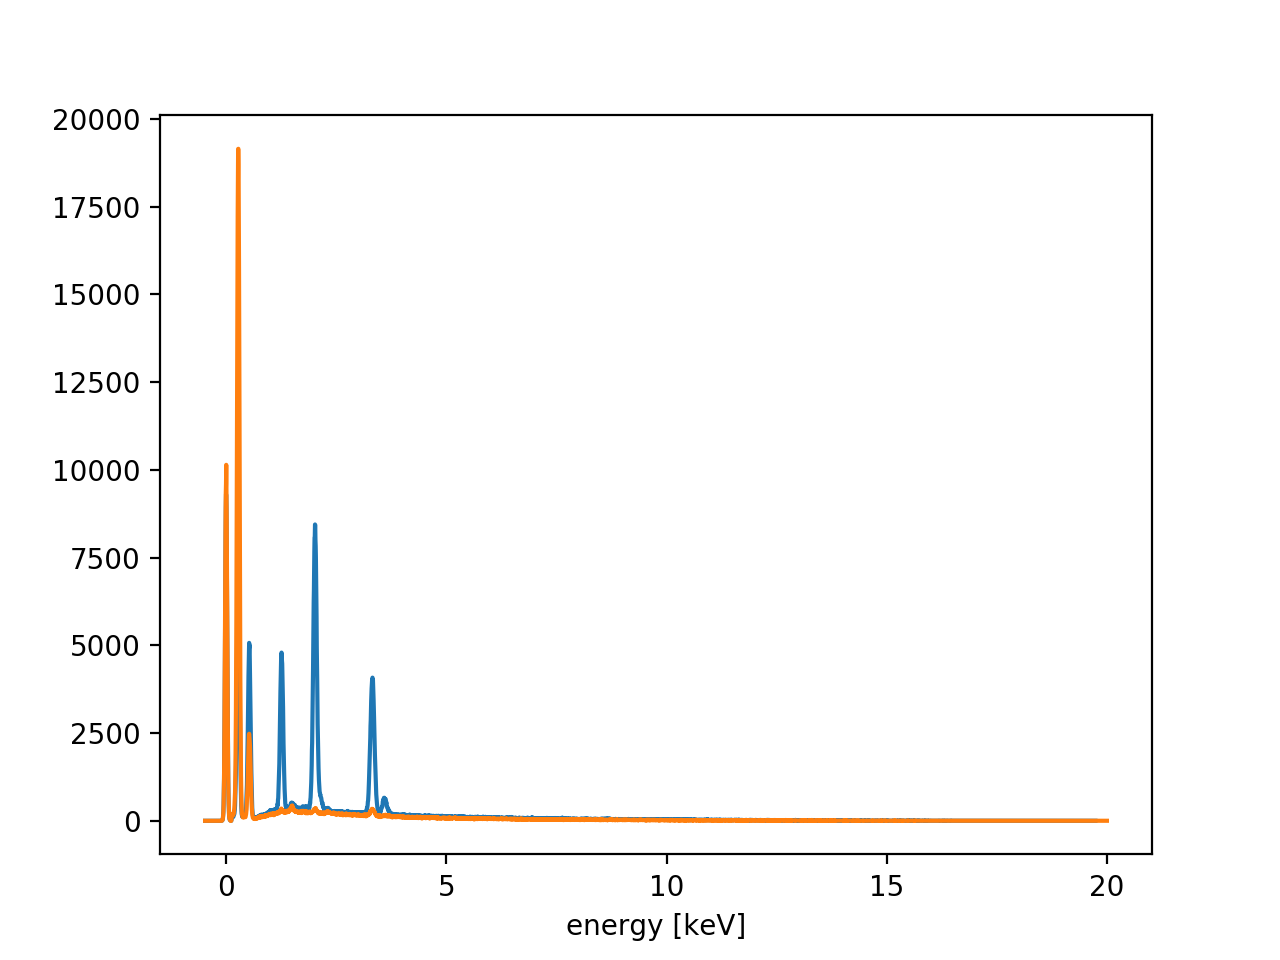

In [4]:
spectrum1 =tags['2']['data']
spectrum2 =tags['3']['data']
offset = float(tags['2']['spectrum_header']['CalibAbs'])
scale  = float(tags['2']['spectrum_header']['CalibLin'])
energy_scale1 = np.arange(len(spectrum1))*scale+offset
offset = float(tags['3']['spectrum_header']['CalibAbs'])
scale  = float(tags['3']['spectrum_header']['CalibLin'])
energy_scale2 = np.arange(len(spectrum2))*scale+offset
plt.figure()
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')
plt.plot(energy_scale2,spectrum2, label = 'spectrum 2')
plt.xlabel('energy [keV]');

<IPython.core.display.Javascript object>


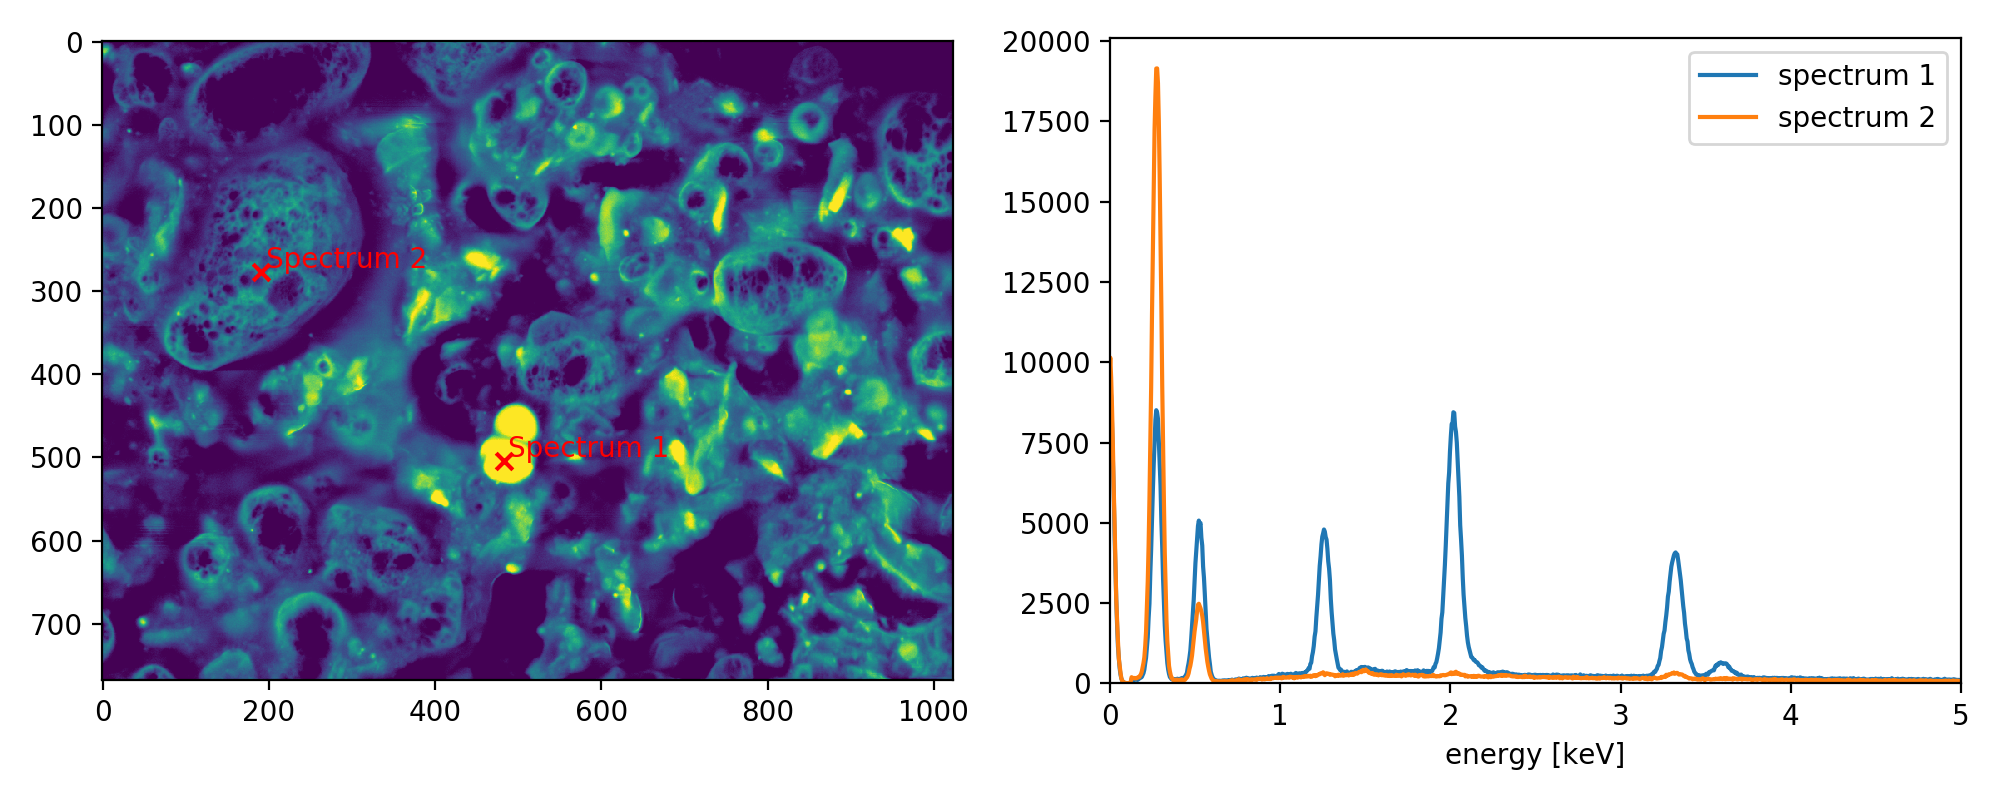

In [5]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
ax1.imshow(tags['image']['0']['data']['0'])
for key in tags['overlay']['image1']:
    d = tags['overlay']['image1'][key]
    ax1.scatter ([d['posX']], [d['posY']], marker="x", color='r')
    ax1.text(d['posX']+5, d['posY']-5, key, color='r')

ax2 = plt.subplot(1,2,2)    
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')
plt.plot(energy_scale2,spectrum2, label = 'spectrum 2')
plt.xlabel('energy [keV]')
plt.xlim(0,5)
plt.ylim(0)
plt.tight_layout()
plt.legend();


## Find Maximas

Of course we can find the maxima with the first derivative

<IPython.core.display.Javascript object>


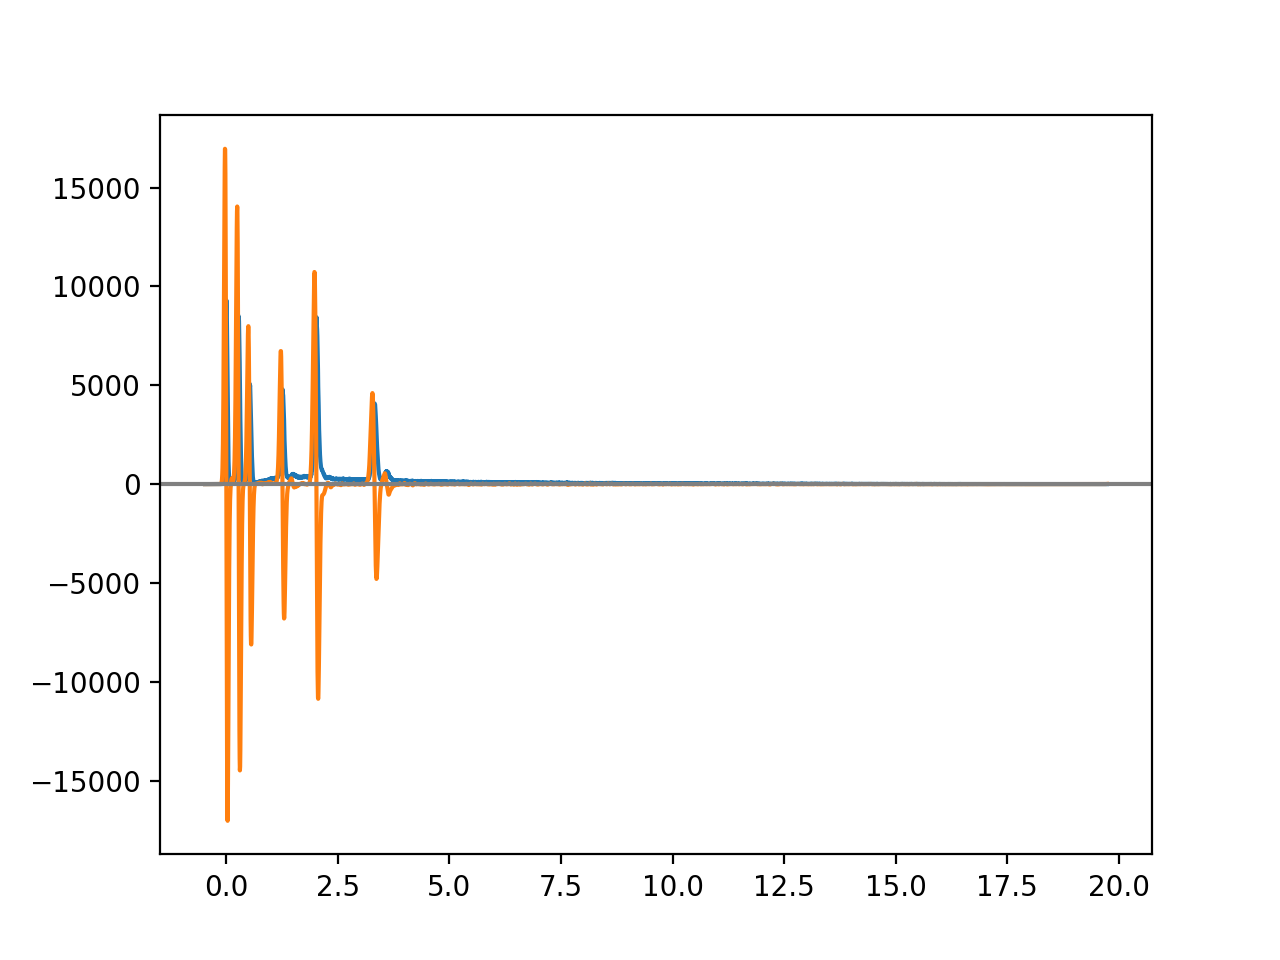

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline

# Get a function that evaluates the linear spline at any x
f = InterpolatedUnivariateSpline(energy_scale1,spectrum1, k=1)

# Get a function that evaluates the derivative of the linear spline at any x
dfdx = f.derivative()

# Evaluate the derivative dydx at each x location...
dydx = dfdx(energy_scale1)
from scipy.ndimage import gaussian_filter


plt.figure()
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')

#plt.plot(energy_scale1, dydx)
plt.plot(energy_scale1,gaussian_filter(dydx, sigma=3)/10)
plt.gca().axhline(y=0,color='gray');

## Peak Finding

We can also use the peak finding routine of the [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) to find all the maxima.


<IPython.core.display.Javascript object>


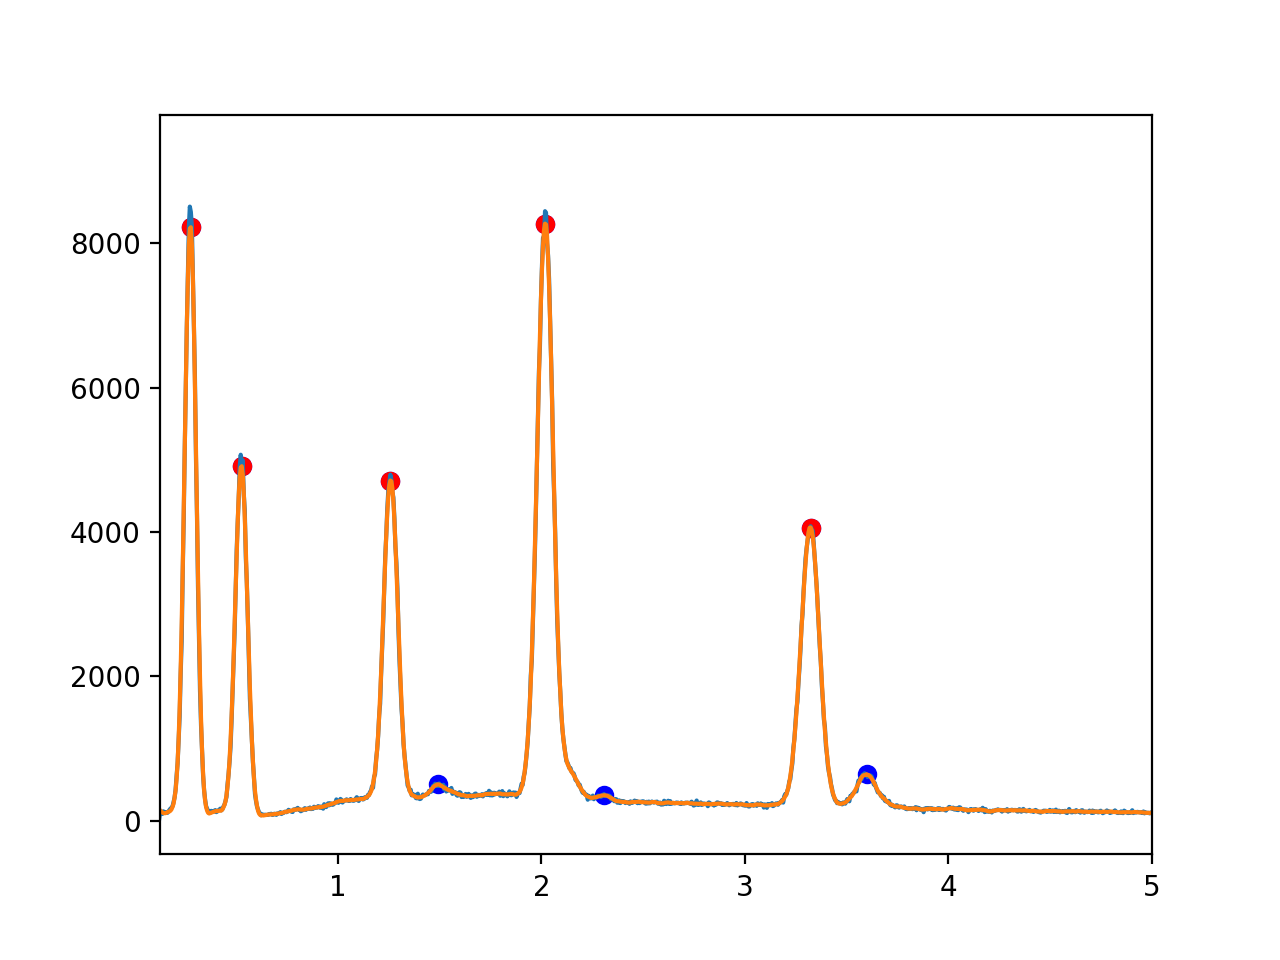

(0.126, 5)

In [7]:
import scipy as sp 
import scipy.signal as sig

start = np.searchsorted(energy_scale1, 0.125)
## we use half the width of the resolution for smearing
width = int(np.ceil(125*1e-3/2 /(energy_scale1[1]-energy_scale1[0])/2)*2+1)
new_spectrum =  sp.signal.savgol_filter(spectrum1[start:], width, 2) ## we use half the width of the resolution for smearing
new_energy_scale = energy_scale1[start:]
major_peaks, _  = sp.signal.find_peaks(new_spectrum, prominence=1000)  
minor_peaks, _  = sp.signal.find_peaks(new_spectrum, prominence=30)  
peaks = major_peaks

spectrum1 = np.array(spectrum1)
plt.figure()
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.scatter( new_energy_scale[minor_peaks], new_spectrum[minor_peaks], color = 'blue')
plt.scatter( new_energy_scale[major_peaks], new_spectrum[major_peaks], color = 'red')

plt.xlim(.126,5)



        
        
        



## Peak identification

Here we look up all the elemetns and see whether the position of major line (K-L3, K-L2' or 'L3-M5') coincides with a peak position as found above.

Then we plot all the lines of such an element with the appropriate weight.

The positions and the weight are tabulated in the **ffast.pkl** file introduced in the [Characteristic X-Ray peaks](CH4-Characteristic_X_Rays.ipynb#X-ray-Weight-of-Lines) notebook

<IPython.core.display.Javascript object>


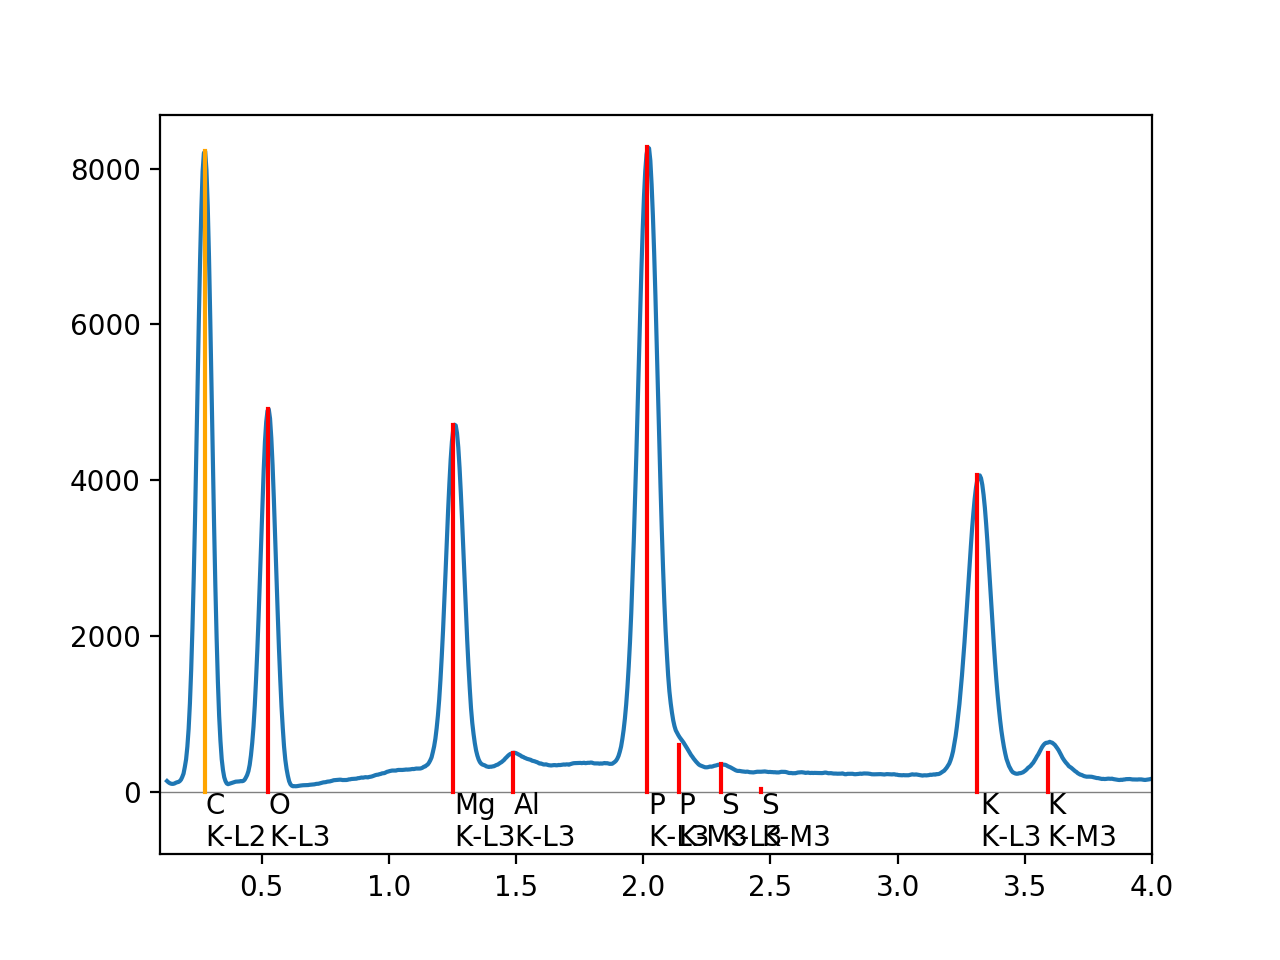

found_element 51 3604.7 3.597909755
C K-L2
O K-L3
Mg K-L3
Al K-L3
P K-L3
S K-L3
K K-L3
Sb L3-M5


In [8]:
import pickle 
pkl_file = open('data/ffast.pkl', 'rb')
ffast = pickle.load(pkl_file)
pkl_file.close()

plt.figure()
#plt.plot(energy_scale1,spectrum2, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.xlim(0.1,4)
plt.ylim(-800)
plt.gca().axhline(y=0,color='gray',  linewidth = 0.5);

out_tags = {}
out_tags['spectra'] = {}

out_tags['spectra'][0] = {}
out_tags['spectra'][0]['data'] = spectrum1
out_tags['spectra'][0]['energy_scale'] = energy_scale1
out_tags['spectra'][0]['energy_scale_start'] = start
out_tags['spectra'][0]['smooth_spectrum'] = new_spectrum
out_tags['spectra'][0]['smooth_energy_scale'] = new_energy_scale

out_tags['spectra'][0]['elements'] ={}


#print(ffast[6])
number_of_elements = 0
for peak in minor_peaks:
    for element in range(1,93):
        if 'K-L3' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L3']['position']- new_energy_scale[peak]*1e3) <10:
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L3'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                number_of_elements += 1
                plt.plot([ffast[element]['lines']['K-L3']['position']/1000.,ffast[element]['lines']['K-L3']['position']/1000.], [0,new_spectrum[peak]], color = 'red')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L3', verticalalignment='top')
                for line in ffast[element]['lines']:
                    if 'K' in line:
                        if abs(ffast[element]['lines'][line]['position']-ffast[element]['lines']['K-L3']['position'])> 20:
                            if ffast[element]['lines'][line]['weight']>0.07:
                                #print(element, ffast[element]['lines'][line],new_spectrum[peak]*ffast[element]['lines'][line]['weight'])
                                plt.plot([ffast[element]['lines'][line]['position']/1000.,ffast[element]['lines'][line]['position']/1000.], [0,new_spectrum[peak]*ffast[element]['lines'][line]['weight']], color = 'red')
                                plt.text(ffast[element]['lines'][line]['position']/1000.,0, ffast[element]['element']+'\n'+line, verticalalignment='top')
                            
        elif 'K-L2' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L2']['position']- new_energy_scale[peak]*1e3) <10:
                plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'orange')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L2', verticalalignment='top')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L2'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                
                number_of_elements += 1
        if 'L3-M5' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['L3-M5']['position']- new_energy_scale[peak]*1e3) <10:
                pass
                print('found_element', element,ffast[element]['lines']['L3-M5']['position'], new_energy_scale[peak] )
                #plt.scatter( new_energy_scale[peak], new_spectrum[peak], color = 'blue')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'L3-M5'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                
                number_of_elements += 1
for element in out_tags['spectra'][0]['elements']:                
    print(out_tags['spectra'][0]['elements'][element]['element'],out_tags['spectra'][0]['elements'][element]['found_lines'])
    

<IPython.core.display.Javascript object>


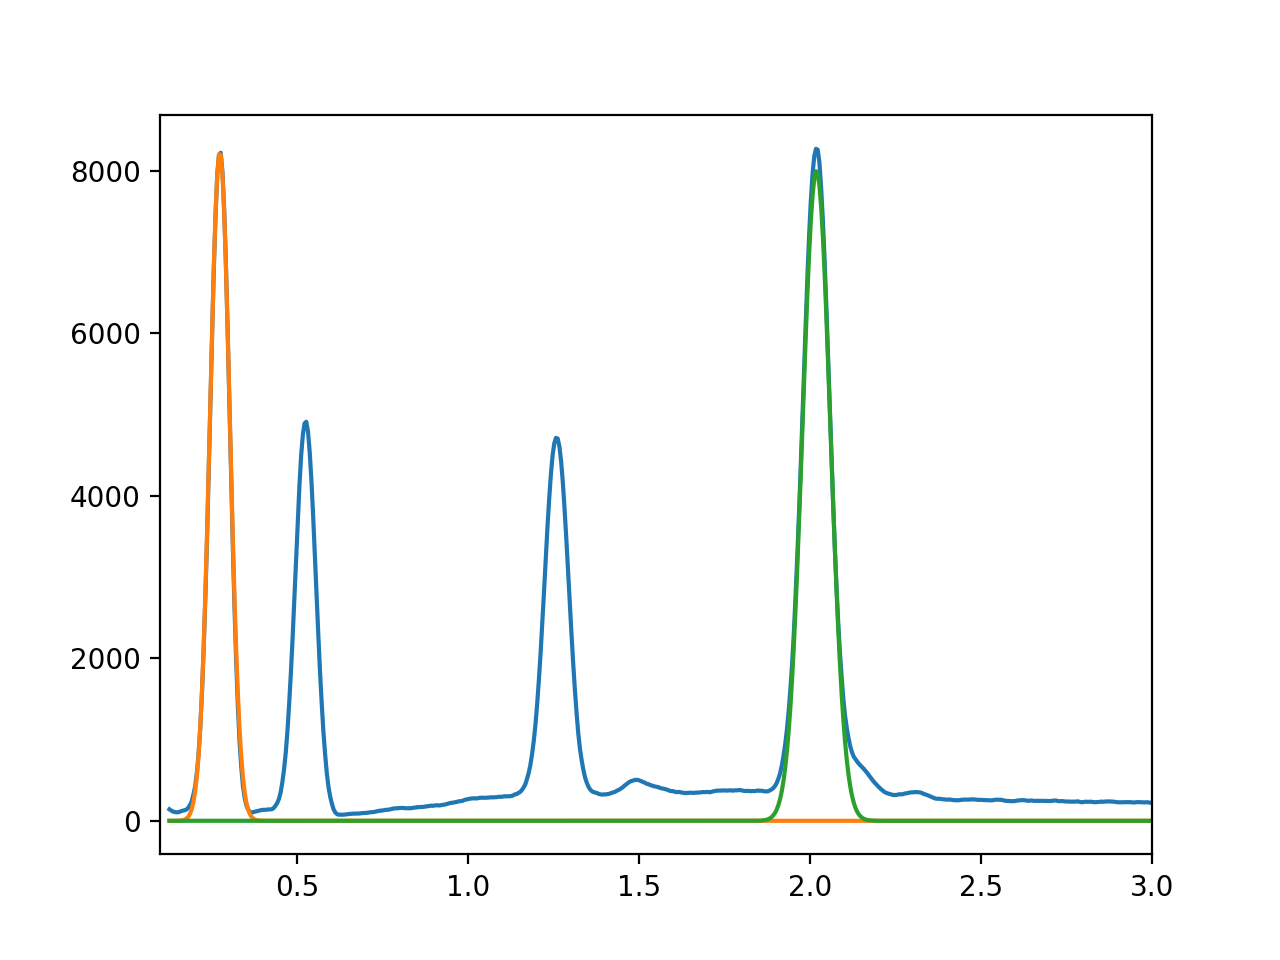

(0.1, 3)

In [11]:
def gaussian(enrgy_scale, mu, FWHM):
    sig = FWHM/2/np.sqrt(2*np.log(2))
    return np.exp(-np.power(enrgy_scale - mu, 2.) / (2 * np.power(sig, 2.)))

C_peak = gaussian(new_energy_scale, .275, .068)
P_peak = gaussian(new_energy_scale, 2.019, .096)
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,C_peak*8233, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,P_peak*8000, label = 'filtered spectrum 1')
plt.xlim(.1,3)

Fiori and Newbury 1978
Mn K-L2,3 peak $E_{ref}$ = 5895 eV and the measured FWHM of the peak $FWHM_{ref}$ in eV, we can estimate the peak width of the other peaks

$$ FWHM =  \sqrt{2.5 \times (E-E_{ref}) + FWHM_{ref}^2 }$$ 

Gernerally we use the 

In [9]:
E_ref = 5895.0
FWHM_ref = 136 #eV
E= 275 
def getFWHM(E):
    return np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)

print(getFWHM(E))

66.6783323126786


<IPython.core.display.Javascript object>


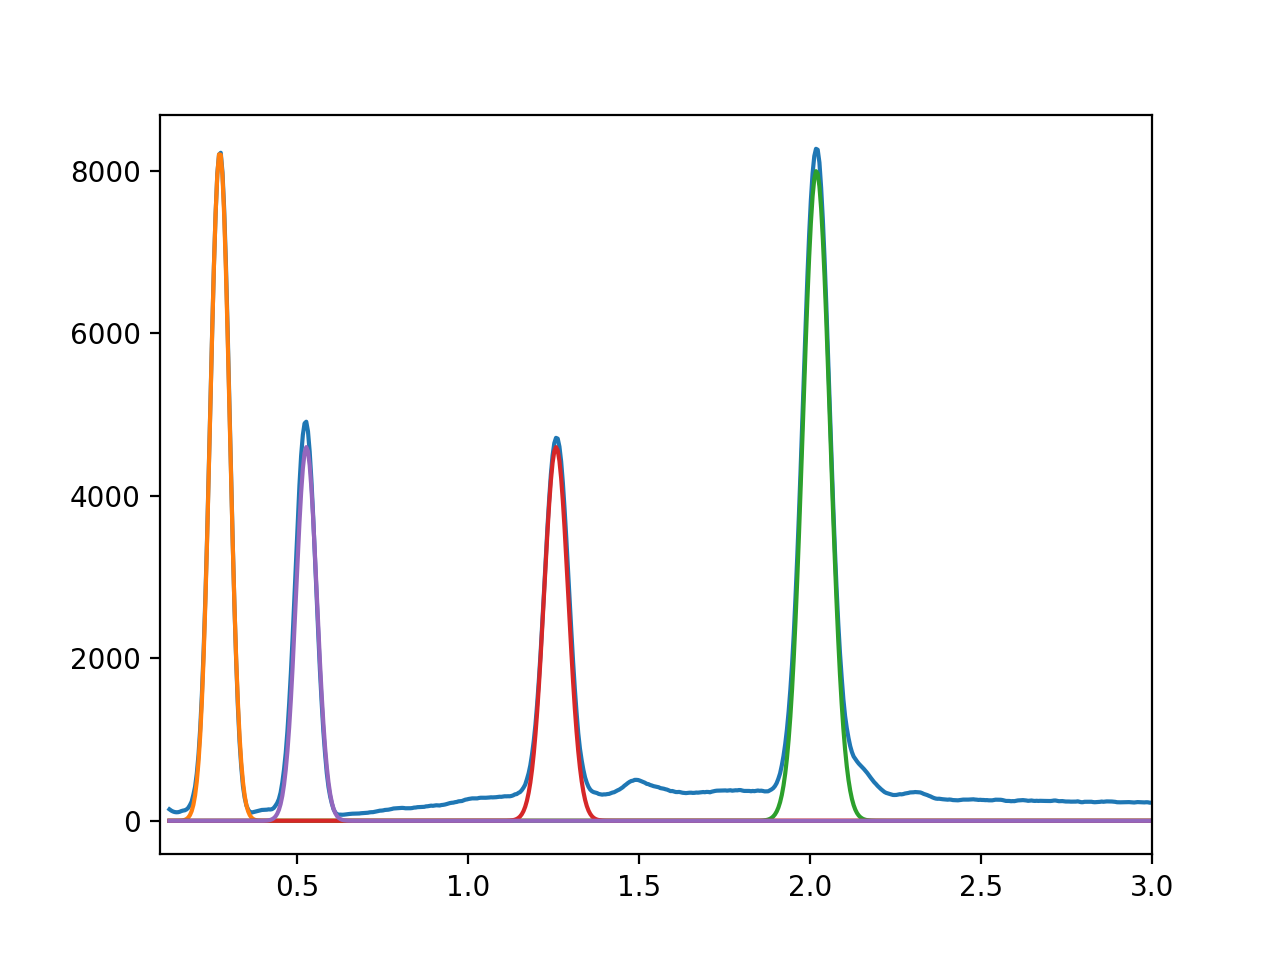

(0.1, 3)

In [12]:
def getPeak(E, energy_scale):
    E_ref = 5895.0
    FWHM_ref = 136 #eV
    FWHM  = np.sqrt(2.5*(E*1e3-E_ref)+FWHM_ref**2)*1e-3
    return gaussian(energy_scale, E, FWHM)
    
E= .275 
C_peak = getPeak(E,new_energy_scale)
E = 2.019
P_peak = getPeak(E,new_energy_scale)
E = 1.258
Al_peak = getPeak(E,new_energy_scale)
E = 0.528
O_peak = getPeak(E,new_energy_scale)
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,C_peak*8233, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,P_peak*8000, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,Al_peak*4600, label = 'filtered spectrum 1')

plt.plot(new_energy_scale,O_peak*4600, label = 'filtered spectrum 1')
plt.xlim(.1,3)

In [13]:
print(out_tags['spectra'][0]['elements'][0])#['K-L2']['weight'] = 0.5
#del out_tags['spectra'][0]['elements'][7]
for ele in out_tags['spectra'][0]['elements']:
    print(out_tags['spectra'][0]['elements'][ele]['element'])
    

{'element': 'C', 'found_lines': 'K-L2', 'lines': {'K-L2': {'weight': 0.5, 'position': 277.40000000000003}}, 'experimental_peak_index': 30, 'experimental_peak_energy': 277.577755}
C
O
Mg
Al
P
S
K
Sb


In [14]:
from scipy.interpolate import interp1d
import scipy.constants as const


## layer thicknesses of commen materials in EDS detectors in m
nickelLayer = 0.* 1e-9 # in m
alLayer = 30 *1e-9    # in m
C_window = 2 *1e-6    # in m
goldLayer = 0.* 1e-9   # in m
deadLayer = 100 *1e-9  # in m
detector_thickness = 45 * 1e-3  # in m

area = 30 * 1e-6 #in m2
oo4pi = 1.0 / (4.0 * np.pi)

#We make a linear energy scale 
energy_scale = new_energy_scale


## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[14]['E']/1000.,ffast[14]['photoabsorption'],kind='linear') 
mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[13]['E']/1000.,ffast[13]['photoabsorption'],kind='linear') 
mu_Al = lin(energy_scale) * ffast[13]['nominal_density'] *100. #1/cm -> 1/m

lin = interp1d(ffast[6]['E']/1000.,ffast[6]['photoabsorption'],kind='linear') 
mu_C = lin(energy_scale) * ffast[6]['nominal_density'] *100. #1/cm -> 1/m
 
detector_Efficiency1 = np.exp(-mu_C * C_window) * np.exp(-mu_Al * alLayer)* np.exp(-mu_Si * deadLayer) 
detector_Efficiency2 = (1.0 - np.exp(-mu_Si * detector_thickness))# * oo4pi;
detector_Efficiency =detector_Efficiency1 * detector_Efficiency2#* oo4pi;

<IPython.core.display.Javascript object>


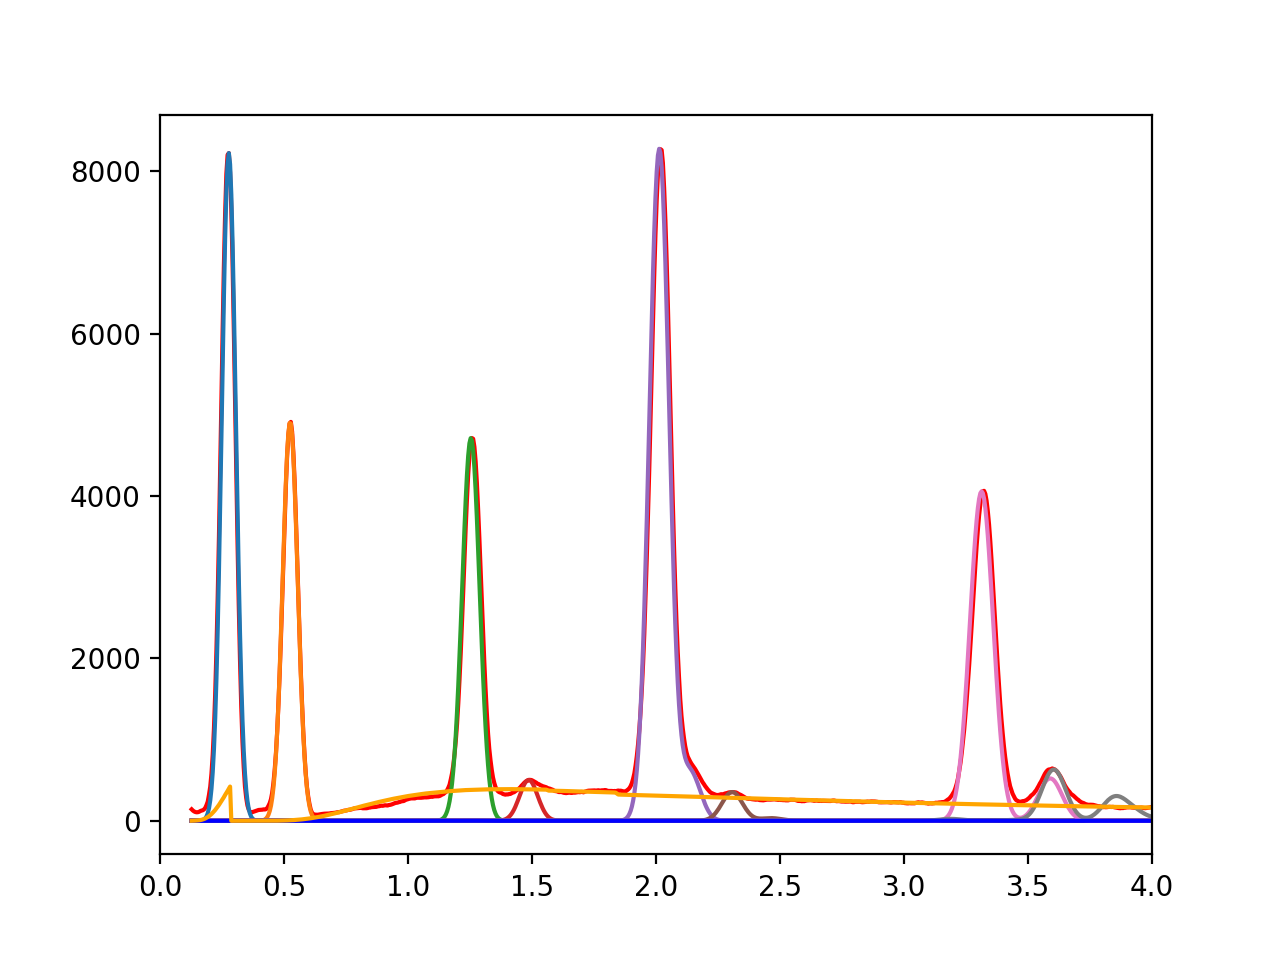

(29, 3922)


(0, 4)

In [15]:
Peaks = []
elements_peaks = []
intensities = []
for element in out_tags['spectra'][0]['elements']:
    el_dict = out_tags['spectra'][0]['elements'][element]
    
    position = el_dict['lines'][el_dict['found_lines']]['position']
    weight = 0
    for line in el_dict['lines']:
        if abs(position - el_dict['lines'][line]['position'])<20:
            weight += el_dict['lines'][line]['weight']
    index = np.searchsorted(new_energy_scale,el_dict['lines'][el_dict['found_lines']]['position']/1000.)  
    intensity = new_spectrum[index]/weight
    added_peaks = np.zeros(len(new_energy_scale))
    for line in el_dict['lines']: 
        if line[0] == el_dict['found_lines'][0]:
            if el_dict['lines'][line]['weight']> 0.01:
                p = getPeak(el_dict['lines'][line]['position']/1000.,new_energy_scale)*el_dict['lines'][line]['weight']
                Peaks.append(p)
                added_peaks = added_peaks + p 
    elements_peaks.append(added_peaks)        
    intensities.append(intensity)
    
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
for i in range(len(elements_peaks)):
    plt.plot(new_energy_scale,elements_peaks[i]*intensities[i], label = f'Peak{i}')
    pass
peaks = np.array(Peaks)
plt.plot(new_energy_scale,peaks.sum(axis=0), label = f'Peaks', color = 'blue')
print(peaks.shape)
#plt.xlim(0,5)    
p = [1, 37, .3]
E_0= 20
E = new_energy_scale
N = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
pp = p[0:3].copy()
for i in range(len(elements_peaks)):
    pp.append(intensities[i])

plt.plot(new_energy_scale,N, color= 'orange')

plt.xlim(0,4)

<IPython.core.display.Javascript object>


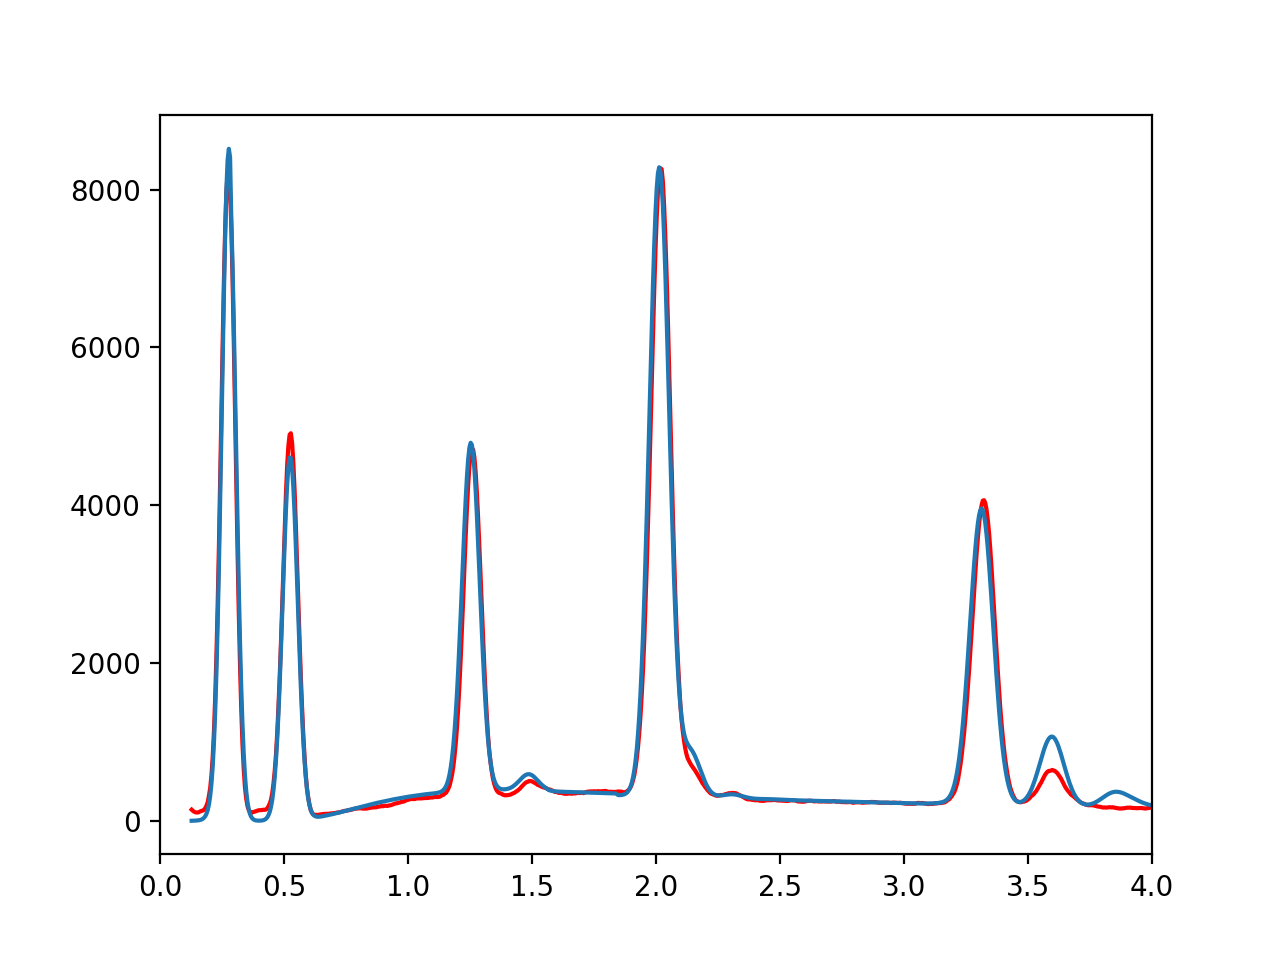

(0, 4)

In [16]:
def model(p,energy_scale):
    E = energy_scale
    spectrum = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
    
    for i in range(3,len(p)):
        spectrum = spectrum+elements_peaks[i-3]*(p[i]-200)
    return spectrum
spectrum3 = model(pp,new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.xlim(0,4)

In [17]:

from scipy.optimize import leastsq 

## background fitting 
def specfit(p, y, x):
    err = y - model(p,x)
    return err

p, lsq = leastsq(specfit, pp, args=(new_spectrum, new_energy_scale), maxfev=2000)


In [18]:
print(p)
print(pp)

[-7.19862617e+00  4.55277961e+01 -3.04766596e-01  1.62364878e+04
  3.47455737e+03  3.04708994e+03  2.89002427e+02  5.43193916e+03
  2.59033011e+02  2.72135312e+03  2.10634992e+02]
[1, 37, 0.3, 16444.494117647144, 3274.62745098041, 3127.7957765720917, 334.63237173223666, 5499.656421488427, 234.956403646351, 2693.245698054643, 568.5437019510302]


<IPython.core.display.Javascript object>


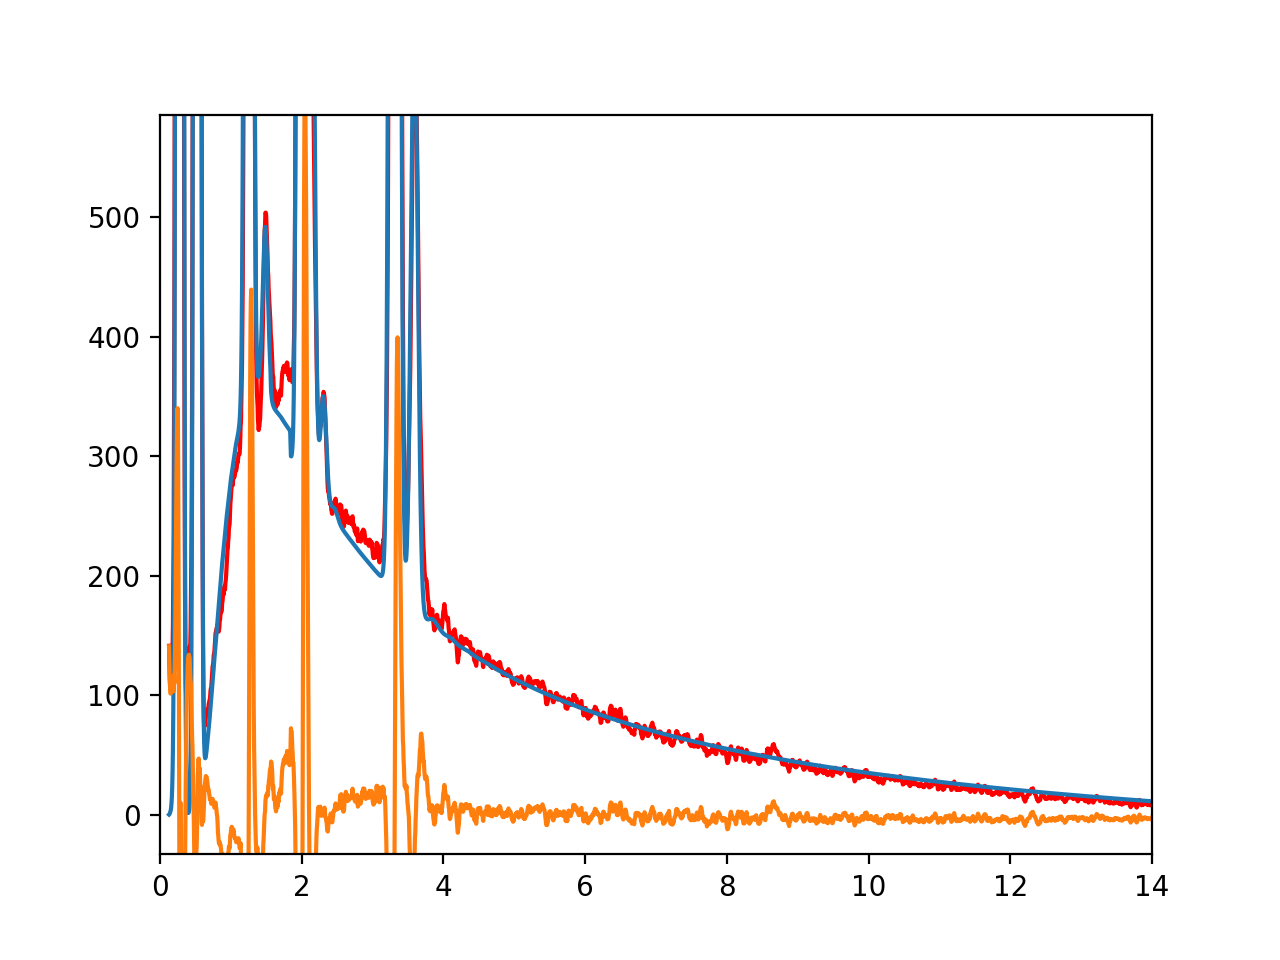

(0, 14)

In [20]:
spectrum3 = model(p,new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.plot(new_energy_scale, new_spectrum-spectrum3)

plt.xlim(0,14)